<a href="https://colab.research.google.com/github/Ali-Sabir2/Open-Source_Matrix_Multiplier_for_Edge_AI/blob/main/Matrix_Multiplier_For_AI_Node.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Open-Source Matrix Multiplier for Edge AI Using Systolic-Booth-Wallace Algorithm**

# **Team Lead**
# Engr. Ali Sabir (ali.sabir@nu.edu.pk)

# **Team Members**

                                                                 
1. Ali Sabir           (ali.sabir@nu.edu.pk)
2. Engr. Mudassir Ali  (i212425@nu.edu.pk)             
3. Engr.Shaheer        (i212435@nu.edu.pk)
4. Dr.Hassan Saif  (hassan.saif@nu.edu.pk)        
5. Dr.Rashad Ramzan (rashad.ramzan@nu.edu.pk)                
 


# **1.1 Summary** 

We have developed a Matrix Multiplier design for AI on edge applications that can be customized by anyone and used in various applications. This design is optimized for efficiency, utilizing Systolic Array parallel computation and a hybrid Modified Booth Wallace tree multiplier as the processing element. The design enhances computational speed while reducing area and power consumption, achieving a big (O) of 2N-1 and power consumption of less than 3W. The design was developed as part of the Code-a-Chip program and is available for submission.

 # **1.2 Motivation**

Machine learning is revolutionizing consumer-based applications, but the process of training a neural network requires intense computation and consumes significant power, often relying on GPUs or ASICs. The real challenge, however, lies in the second stage: inference. When running a trained neural network to classify data or estimate values, consumer end devices face strict area and power constraints, leading to slow performance and compromised real-time processes. We propose a solution: a parallel computation matrix multiplier that accelerates multiplication and accumulation operations, drastically reducing power consumption and outperforming general-purpose micro-controllers for AI on edge applications

# **1.3 Proposed Design** 
* **Matrix Multiplication Using Systolic Array**

    In this project, we will implement parallel computation for energy efficient and fast matrix multiplication. The algorithm that we are using for matrix multiplication is systolic array as shown in Figure 1. It uses  processing elements (PE) [1] [2]. Conventional matrix multiplication gives an output after  steps whereas the output of systolic array is  which is quite faster than conventional matrix multiplication [3]. For example, if we are multiplying two 3x3 matrices, we would employ 5x5 PEs and output would occur at T=8.

  The computation of systolic array is implemented in such a way that for T=1; 1st row and 1st column of matrix A and B respectively is input into the array. The output is propagated diagonally as shown in Figure 1 as  where  is previous output. At T=2; 2nd row and 2nd column of matrix A and B is entered into the array. If A is our input matrix and B is our weights matrix then the input data flow propagates from top to bottom and weights data flow propagates from left to right.


* **Modified Booth Wallace Multiplier:**
  
  As we are implementing an algorithm that does parallel computation with limited power and area, so we are integrating Modified Booth Wallace Multiplier as our PE in our matrix multiplication algorithm [4].

  It consists of four major modules: Booth encoder, partial product generator, Wallace tree formation and a fast adder such as Carry Look ahead Adder as shown in Figure 2.

  The Modified Booth algorithm reduces partial product by  for Radix-4 encoding and by  for Radix-8 encoding [5]. We are using Modified Booth to reduce area and by using Wallace tree, we are reducing our delay thus making Modified Booth Wallace Tree one of the fastest energy efficient multiplies.
  
  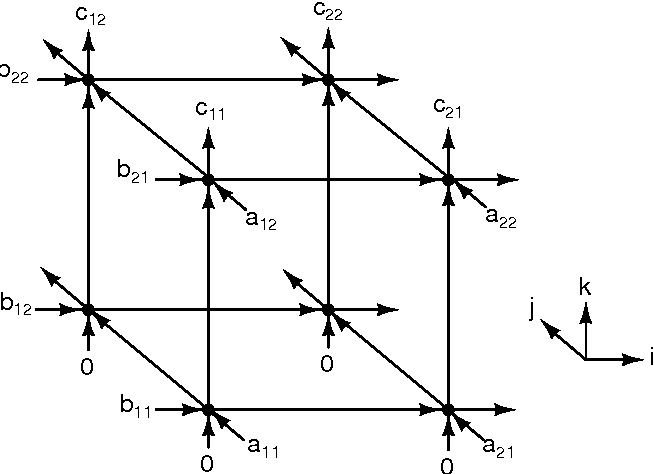

Figure 1 Matrix multiplication using systolic array algorithm representation





  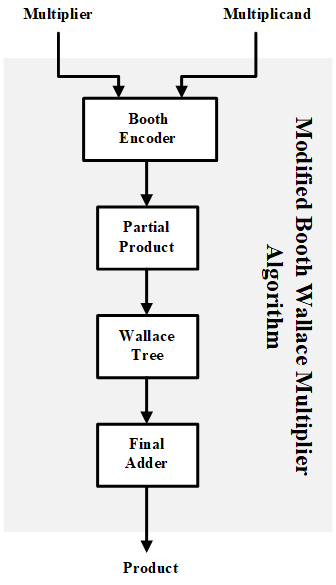

  Figure 2 Modified Booth Wallace multiplier algorithm representation


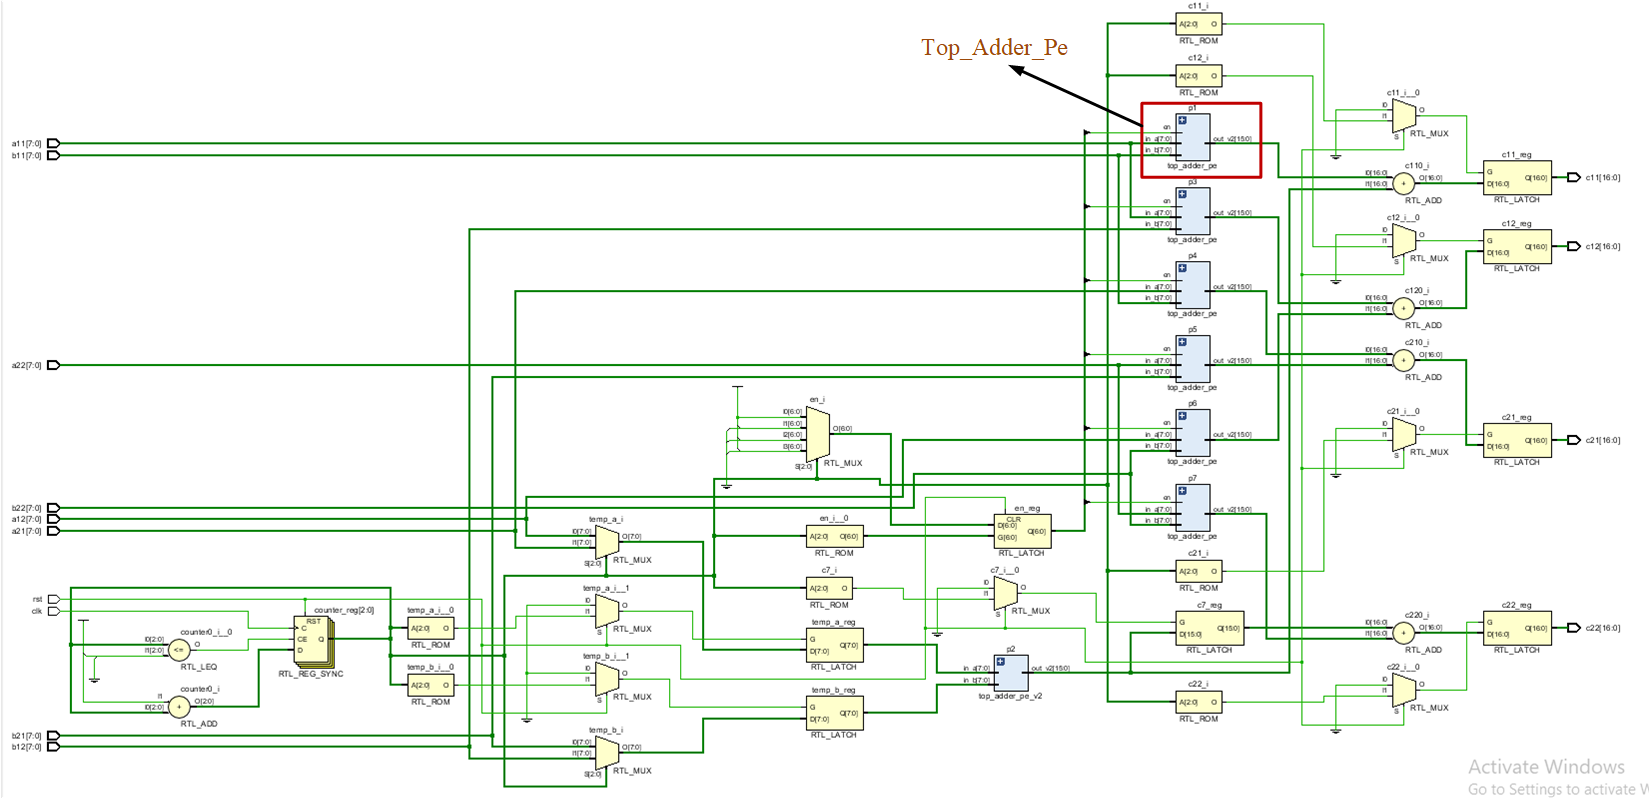

Fig 3. Schematic of Systollic Array based Matrix Multiplier

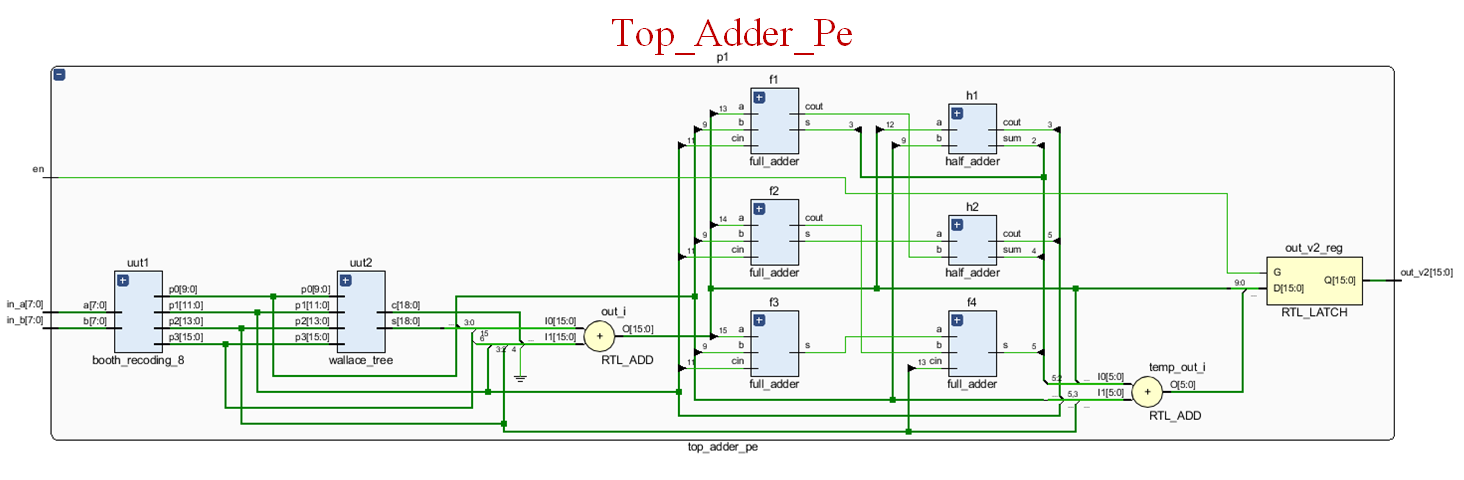

Fig 4. Schematic of Top_Adder_Pe

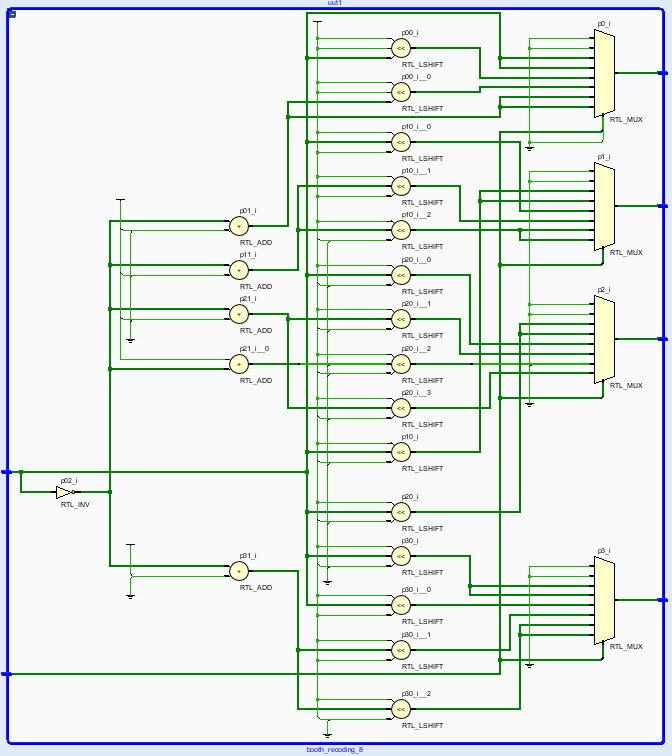

Fig 5. Schematic of 8x8 Booth Recoding 
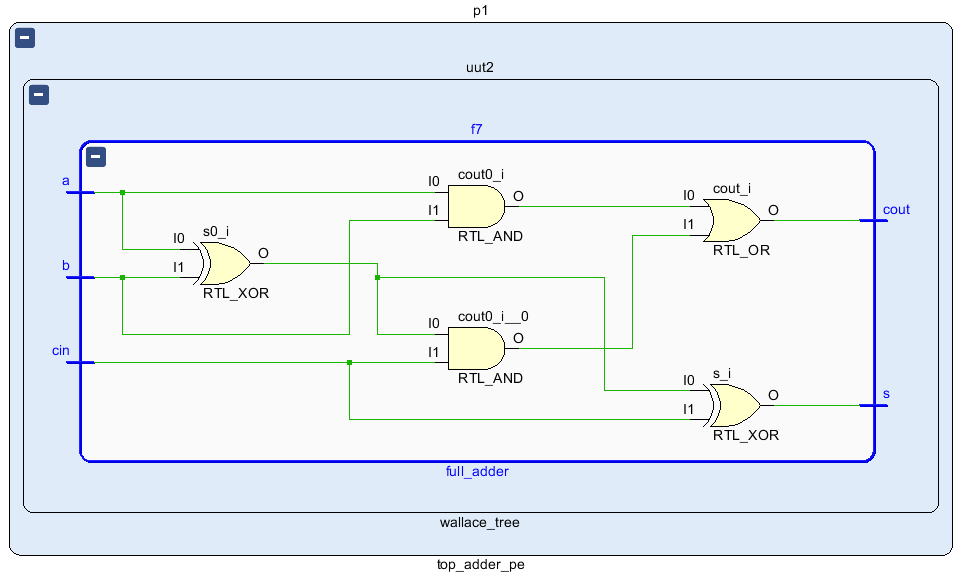

Fig 6. Schematic of Full Adder



# **1.4 Project Specifications**

The proposed design specifications are given below:


  

1.   Power Consumption             **<3W**
2.   Throughput                   **1GOPs**
3.   Big (O)                      **2N-1**

# **2. Design Flow**

In [ ]:
#@title  Install Required Dependencies for the Flow  {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_version = 'latest' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''
if open_pdks_version == 'latest':
  open_pdks_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version} \
                     open_pdks.sky130a={open_pdks_version}
!python -m pip install gdstk gdstk
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


## **2.1 Verilog Code of Matrix Multiplier using Systolic-Booth-Wallace Algorithm** 

In [ ]:
%%writefile systolic_array.v
module systolic_array( a11,a12,a21,a22, b11, b12, b21, b22, clk, c11, c12, c21, c22,rst);
//matrix "a" inputs
input signed [7:0] a11;
input signed [7:0] a12;
input signed [7:0] a21;
input signed [7:0] a22;

//matrix "b" inputs
input signed [7:0] b11;
input signed [7:0] b12;
input signed [7:0] b21;
input signed [7:0] b22;

//clk input
input clk;

//rst input
input rst;

//output reg
output reg signed [16:0] c11;
output reg signed [16:0] c12;
output reg signed [16:0] c21;
output reg signed [16:0] c22;

//counter register to know "T"
reg [2:0] counter;
//reg [2:0] counter2;

//enable for PE
reg [6:0] en;

reg signed [7:0]  temp_a;
reg signed [7:0]  temp_b;
wire signed [15:0] temp_c;

//wires & reg to store products
wire signed [15:0] c1;
reg  signed [15:0] c2;
wire signed [15:0] c3;
wire signed [15:0] c4;
wire signed [15:0] c5;
wire signed [15:0] c6;
reg signed  [15:0] c7;
wire signed [15:0] c8;

//PE initiation
top_adder_pe 				p1 (.in_a (a11)    	, . in_b(b11)     , .out_v2(c1)		, .en(en[0]) );
top_adder_pe_v2 			p2 (.in_a (temp_a) 	, . in_b(temp_b)  , .out_v2(temp_c)              );
top_adder_pe 				p3 (.in_a (a11)    	, . in_b(b12)     , .out_v2(c3)		, .en(en[2]) );
top_adder_pe 				p4 (.in_a (a21)    	, . in_b(b11)	   , .out_v2(c4)		, .en(en[3]) );
top_adder_pe 				p5 (.in_a (a22)		, . in_b(b21)		, .out_v2(c5)		, .en(en[4]) );
top_adder_pe 				p6 (.in_a (a12)		, . in_b(b22)		, .out_v2(c6)		, .en(en[5]) );
top_adder_pe 				p7 (.in_a (a22)		, . in_b(b22)		, .out_v2(c8)		, .en(en[6]) );

always @ (counter)
begin

if(rst)
en[6:0] = 0;

else
begin

case (counter)

3'b010 : begin
en[0] = 1;
//counter = counter +1;
end

3'b011 : begin
temp_a  = a12;
temp_b  = b21;

en[2]   = 1  ;
en[3]   = 1  ;
en[0]   = 0  ;
//counter = counter +1;
//c2      = temp_c;
end

3'b100 : begin
c2     = temp_c;
temp_a = a21;
temp_b = b12;
//c7     = temp_c;
en[4]  = 1;
en[5]  = 1;
c11    = c1 + c2;
en[3]  = 0;
en[2]  = 0;
//counter = counter +1;
end

3'b101: begin
c7      = temp_c;
c21     = c4 + c5; //c21
c12     = c3 + c6;
en[6]   = 1;
//c22    = c7 + c8;
en[4]   = 0;
en[5]	  = 0;
//counter = counter + 1;	
end

3'b110: begin
c22 = c7 + c8;
end

endcase
end
 
end

always @ (posedge clk)
begin

if(rst)
counter <= 0;

else if (counter <= 6 )
counter <= counter + 1;

else
counter <= counter;

end


//COMMENTED FOR SIMULATION AND REMOVE RACE CONDITION 
//always @ (a11)
//begin
//en[6:0]  = 0 ;
//counter  = 0 ;
//end

//END OF COMMENTS

//initial begin
//en[6:0] = 0;
//counter = 0;
//end

endmodule

module top_adder_pe_v2 (in_a,in_b, out_v2);
wire   signed [15:0] a;
wire   signed [15:0] b;
input  signed [7:0]  in_a;			//in_a is "x"
input  signed [7:0]  in_b;   		
output 		  [15:0] out_v2;

wire   		  [16:0] out; 

wire signed [9:0]  p0_wire;
wire signed [11:0] p1_wire;
wire signed [13:0] p2_wire;
wire signed [15:0] p3_wire;

wire signed [18:0] s_wire;
wire signed [18:0] c_wire;

wire [5:0] temp_out;
wire [5:0] ss;
wire [5:0] cc;
wire [5:0] temp_a;
wire [5:0] temp_b;

assign b[1:0] = 0;

booth_recoding_8 uut1 (.a(in_a), .b(in_b), .p0(p0_wire), .p1(p1_wire), .p2(p2_wire), .p3(p3_wire)); 					//calling booth_recoder
     
wallace_tree uut2 ( .p0(p0_wire), .p1(p1_wire), .p2(p2_wire), .p3(p3_wire), .s(s_wire), .c(c_wire) ); 				// calling wallace tree	

assign a[3:0]   = p0_wire[3:0];				// "a" started
assign a[4]     = s_wire[0];
assign a[5]     = s_wire[1];
assign a[9:6]   = s_wire[11:8];
assign a[10]	 = s_wire[13]	;	
assign a[14:11] = s_wire[18:15];
assign a[15]	 = p3_wire[15]	;			//"a" ended

assign b[3:2]  = p1_wire[3:2];				//"b" ended
assign b[4]    = p2_wire[4];
assign b[5]    = c_wire[0];
assign b[6]    = p3_wire[6];
assign b[10:7] = c_wire [11:8];
assign b[11]   = c_wire [13];
assign b[12]   = c_wire [15];
assign b[15:13]= c_wire [18:16];			//"b" ended

assign out =a + b;

//2nd wallace tree

//1st stage
half_adder h1 ( .a ( out[12] ),  .b ( p0_wire[9] ),  .sum ( ss[0]  ),  .cout ( cc[0] ) );
full_adder f1 ( .a ( out[13] ),  .b ( p0_wire[9] ),  .cin ( p1_wire[11]  ),  .s    ( ss[1] )   , .cout (cc[1]) ); 
full_adder f2 ( .a ( out[14] ),  .b ( p0_wire[9] ),  .cin ( p1_wire[11]  ),  .s    ( ss[2] )   , .cout (cc[2]) );
full_adder f3 ( .a ( out[15] ),  .b ( p0_wire[9] ),  .cin ( p1_wire[11]  ),  .s    ( ss[3] )   , .cout (cc[3]) );

//2nd stage
half_adder h2 ( .a ( ss[2]   ),  .b ( cc[1] ),       .sum ( ss[4]   ),   .cout ( cc[4] ) );
full_adder f4 ( .a ( ss[3]   ),  .b ( cc[2] ),  .cin ( p2_wire[13]  ),   .s    ( ss[5] )   , .cout (cc[5]) );

//3rd stage
//half_adder h3 ( .a ( out[16]   ),  .b ( cc[3] ),       .sum ( ss[6]   ),   .cout ( cc[6] ) );

//END of 2nd wallace tree

assign temp_a[1:0] = out[11:10];
assign temp_a[3:2] = ss [1:  0];
assign temp_a[5:4] = ss [5:  4];

assign temp_b [0]   = p0_wire [9 ];
assign temp_b [1]   = p0_wire [9 ];
assign temp_b [2]   = p1_wire [11];
assign temp_b [3]   = cc	   [0 ];
assign temp_b [4]   = p2_wire [13];
assign temp_b [5]   = cc       [4];

assign temp_out    = temp_a + temp_b;

//assign out[16:10] = temp_out[6:0];

assign out_v2[9:0]   = out[9:0]			;
assign out_v2[15:10] = temp_out[5:0] 	;

endmodule

module top_adder_pe (in_a,in_b,en, out_v2);
wire   signed [15:0] a			;
wire   signed [15:0] b			;
input  signed [7:0]  in_a		;			//in_a is "x"
input  signed [7:0]  in_b		; 
input						en	 		;  		
output reg	  [15:0] out_v2	;

wire	 		  [16:0] out		; 

wire signed [9:0]  p0_wire;
wire signed [11:0] p1_wire;
wire signed [13:0] p2_wire;
wire signed [15:0] p3_wire;

wire signed [18:0] s_wire;
wire signed [18:0] c_wire;

wire [5:0] temp_out;
wire [5:0] ss;
wire [5:0] cc;
wire [5:0] temp_a;
wire [5:0] temp_b;

assign b[1:0] = 0;

booth_recoding_8 uut1 (.a(in_a), .b(in_b), .p0(p0_wire), .p1(p1_wire), .p2(p2_wire), .p3(p3_wire)); 					//calling booth_recoder
     
wallace_tree uut2 ( .p0(p0_wire), .p1(p1_wire), .p2(p2_wire), .p3(p3_wire), .s(s_wire), .c(c_wire) ); 				// calling wallace tree	

assign a[3:0]   = p0_wire[3:0];				// "a" started
assign a[4]     = s_wire[0];
assign a[5]     = s_wire[1];
assign a[9:6]   = s_wire[11:8];
assign a[10]	 = s_wire[13]	;	
assign a[14:11] = s_wire[18:15];
assign a[15]	 = p3_wire[15]	;			//"a" ended

assign b[3:2]  = p1_wire[3:2];				//"b" ended
assign b[4]    = p2_wire[4];
assign b[5]    = c_wire[0];
assign b[6]    = p3_wire[6];
assign b[10:7] = c_wire [11:8];
assign b[11]   = c_wire [13];
assign b[12]   = c_wire [15];
assign b[15:13]= c_wire [18:16];			//"b" ended

assign out =a + b;


//2nd wallace tree

//1st stage
half_adder h1 ( .a ( out[12] ),  .b ( p0_wire[9] ),  .sum ( ss[0]  ),  .cout ( cc[0] ) );
full_adder f1 ( .a ( out[13] ),  .b ( p0_wire[9] ),  .cin ( p1_wire[11]  ),  .s    ( ss[1] )   , .cout (cc[1]) ); 
full_adder f2 ( .a ( out[14] ),  .b ( p0_wire[9] ),  .cin ( p1_wire[11]  ),  .s    ( ss[2] )   , .cout (cc[2]) );
full_adder f3 ( .a ( out[15] ),  .b ( p0_wire[9] ),  .cin ( p1_wire[11]  ),  .s    ( ss[3] )   , .cout (cc[3]) );

//2nd stage
half_adder h2 ( .a ( ss[2]   ),  .b ( cc[1] ),       .sum ( ss[4]   ),   .cout ( cc[4] ) );
full_adder f4 ( .a ( ss[3]   ),  .b ( cc[2] ),  .cin ( p2_wire[13]  ),   .s    ( ss[5] )   , .cout (cc[5]) );

//3rd stage
//half_adder h3 ( .a ( out[16]   ),  .b ( cc[3] ),       .sum ( ss[6]   ),   .cout ( cc[6] ) );

//END of 2nd wallace tree

assign temp_a[1:0] = out[11:10];
assign temp_a[3:2] = ss [1:  0];
assign temp_a[5:4] = ss [5:  4];

assign temp_b [0]   = p0_wire [9 ];
assign temp_b [1]   = p0_wire [9 ];
assign temp_b [2]   = p1_wire [11];
assign temp_b [3]   = cc	   [0 ];
assign temp_b [4]   = p2_wire [13];
assign temp_b [5]   = cc       [4];

assign temp_out    = temp_a + temp_b;

//assign out[16:10] = temp_out[6:0];

always @ (*)
begin

if (en)
begin
out_v2[9:0]   = out[9:0]			;
out_v2[15:10] = temp_out[5:0] 	;
end

else
out_v2 = out_v2						;

end

endmodule


module wallace_tree ( p0, p1, p2, p3, s , c);
input     [9:0]  p0;
input     [11:0] p1;
input     [13:0] p2;
input     [15:0] p3;
output    [18:0] s ;    				// sum is "s"
output    [18:0] c ;					// carry is "c"



//1st stage
half_adder h1 ( .a ( p0[4] ),  .b ( p1[4] ),  .sum ( s[0]  ),  .cout (c[0]) );
full_adder f1 ( .a ( p0[5] ),  .b ( p1[5] ),  .cin ( p2[5] ),  .s ( s[1] ), .cout (c[1]) ); 
full_adder f2 ( .a ( p0[6] ),  .b ( p1[6] ),  .cin ( p2[6] ),  .s ( s[2] ), .cout (c[2]) );
full_adder f3 ( .a ( p0[7] ),  .b ( p1[7] ),  .cin ( p2[7] ),  .s ( s[3] ), .cout (c[3]) );
full_adder f4 ( .a ( p0[8] ),  .b ( p1[8] ),  .cin ( p2[8] ),  .s ( s[4] ), .cout (c[4]) );
full_adder f5 ( .a ( p0[9] ),  .b ( p1[9] ),  .cin ( p2[9] ),  .s ( s[5] ), .cout (c[5]) );
full_adder f6 ( .a ( p1[10] ), .b ( p2[10] ), .cin ( p3[10] ), .s ( s[6] ), .cout (c[6]) );
full_adder f7 ( .a ( p1[11] ), .b ( p2[11] ), .cin ( p3[11] ), .s ( s[7] ), .cout (c[7]) );

//2nd stage
half_adder h2  ( .a ( s[2] 	), .b ( c[1] 	), .sum ( s[8]  ), .cout (c[8]	) );
full_adder f8  ( .a ( s[3] 	), .b ( c[2] 	), .cin ( p3[7] ), .s ( s[9] ), .cout (c[9]) );
full_adder f9  ( .a ( s[4] 	), .b ( c[3] 	), .cin ( p3[8] ), .s ( s[10] ), .cout (c[10]) );
full_adder f10 ( .a ( s[5] 	), .b ( c[4] 	), .cin ( p3[9] ), .s ( s[11] ), .cout (c[11]) );
half_adder h3  ( .a ( p2[12] 	), .b ( p3[12] ), .sum ( s[12]  ), .cout (c[12]	) );

//3rd stage
half_adder h4  ( .a ( s[6] 	), 	.b ( c[5] 	), .sum ( s[13]  ), .cout (c[13]) );
half_adder h5  ( .a ( p2[13] 	), 	.b ( p3[13] ), .sum ( s[14]  ), .cout (c[14]	) );


//4th stage
half_adder h6  ( .a ( s[7] ), 	.b ( c[6] ), .sum ( s[15]  ), .cout (c[15]) );

//5th stage
half_adder h7  ( .a ( s[12] ), 	.b ( c[7] ), .sum ( s[16]  ), .cout (c[16]) );

//6th stage
half_adder h8  ( .a ( s[14] ), 	.b ( c[12] ), .sum ( s[17]  ), .cout (c[17]) );

//7th stage
half_adder h9  ( .a ( p3[14] ), 	.b ( c[14] ), .sum ( s[18]  ), .cout (c[18]) );


endmodule
module booth_recoding_8 (a, b, p0, p1, p2, p3);
input signed [7:0] a;                    //a=x
input signed [7:0] b;			 // b is stored in temp and truth table is checked on "b"
output  reg signed  [9:0]  p0;
output  reg signed  [11:0] p1;
output  reg signed  [13:0] p2;
output  reg signed  [15:0] p3;
reg  [8:0] temp;
reg signed [7:0] inv_temp;
always @ (*)
begin
temp [8:1]= b;        			// b is stored in temp from bit [8] to [1]. Bit[0] stores "0"
temp [0] = 0;
case (temp [2:0] )
3'b000 : p0 = 0;
3'b111 : p0 = 0;
3'b001 : p0 = a;
3'b010 : p0 = a;
3'b011 : p0 = a<<1;
3'b100 : begin 
inv_temp = ~a ;
p0 = inv_temp;
p0 = p0 + 1;
p0 = p0 << 1;
end
3'b101 : begin 
inv_temp = ~a ;
p0 = inv_temp;
p0 = p0 + 1;
end
3'b110 : begin 
inv_temp = ~a ;
p0 = inv_temp;
p0 = p0 + 1;
end
endcase

case (temp [4:2] )
3'b000 : p1 = 0;
3'b111 : p1 = 0;
3'b001 : p1 = a<<2;
3'b010 : p1 = a<<2;
3'b011 : p1 = a<<3;
3'b100 : begin 
inv_temp = ~a ;

p1 = inv_temp;
p1 = p1 + 1;
p1 = p1 << 3;

end

3'b101 : begin 
inv_temp = ~a;

p1 = inv_temp;
p1 = p1 + 1;
p1 = p1 << 2;

end

3'b110 : begin 
inv_temp = ~a ;

p1 = inv_temp;
p1 = p1 +  1;
p1 = p1 << 2;

end
endcase

case (temp [6:4] )
3'b000 : p2 = 0;
3'b111 : p2 = 0;
3'b001 : p2 = a<<4;
3'b010 : p2 = a<<4;
3'b011 : p2 = a<<5;
3'b100 : begin 
inv_temp = ~a ;
p2 = inv_temp;
p2 = p2 + 1;
p2 = p2 << 5;

end

3'b101 : begin 
inv_temp = ~a ;
p2 = inv_temp;
p2 = p2 +  1;
p2 = p2 << 4;

p2 = (inv_temp + 1'b1) << 4 ;
end

3'b110 : begin 
inv_temp = ~a ;
p2 = inv_temp;
p2 = p2 + 1;
p2 = p2 << 4;

end
endcase

case (temp [8:6] )
3'b000 : p3 = 0;
3'b111 : p3 = 0;
3'b001 : p3 = a<<6;
3'b010 : p3 = a<<6;
3'b011 : p3 = a<<7;
3'b100 : begin 
inv_temp = ~a ;
p3 = inv_temp;
p3 = p3 +  1;
p3 = p3 << 7;

end

3'b101 : begin 
inv_temp = ~a ;
p3 = inv_temp;
p3 = p3 +  1;
p3 = p3 << 6;

end

3'b110 : begin 
inv_temp = ~a ;
p3 = inv_temp;
p3 = p3 +  1;
p3 = p3 << 6;

end
endcase
end
endmodule


module full_adder (a, b, cin, s, cout);

input  signed a;
input  signed b;
input  signed cin;
output signed s; 
output signed cout;


assign s = (a ^ b) ^ cin;
assign cout = (a & b) | ( (a ^ b) & cin) ;

endmodule

module half_adder(a,b,sum,cout);
input  signed a;
input  signed b;
output signed sum;
output signed cout;


assign sum = a^b;                // "^" is XOR bitwise operator                
assign cout = a & b;             // "&" is AND bitwise operator        
           
endmodule






Overwriting systolic_array.v


## **Installing the Opensource Verilog Simulator "iverilog"** 

In [ ]:

!apt install iverilog
!apt install gtkwave

## **2.2 Verification of the Module**
To put our code to the test and verify its accuracy, let's consider two matrices A and B, and use them to compute their product C=AXB. We'll showcase this example in the notebook submission for the Code a Chip contest. Additionally, we've included a test bench that utilizes the same values for A and B to generate the result, ensuring that our code performs as expected


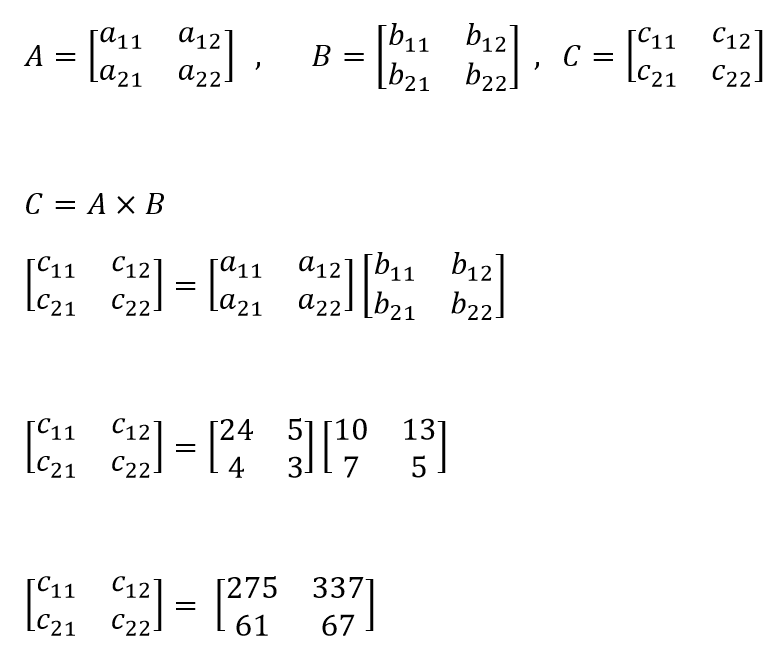

In [ ]:
%%writefile systolic_array_tb.v
module systolic_array_tb;

  // Declare input signals
  reg [7:0] a11;
  reg [7:0] a12;
  reg [7:0] a21;
  reg [7:0] a22;
  reg [7:0] b11;
  reg [7:0] b12;
  reg [7:0] b21;
  reg [7:0] b22;
  reg clk;
  reg rst;

  // Declare output signals
  wire [16:0] c11;
  wire [16:0] c12;
  wire [16:0] c21;
  wire [16:0] c22;

  // Instantiate the Unit Under Test (UUT)
  systolic_array UUT(
    .a11(a11),
    .a12(a12),
    .a21(a21),
    .a22(a22),
    .b11(b11),
    .b12(b12),
    .b21(b21),
    .b22(b22),
    .clk(clk),
    .c11(c11),
    .c12(c12),
    .c21(c21),
    .c22(c22),
    .rst(rst)
  );

  // Initialize input signals
  initial begin
    $dumpfile("systolic_array_tb.vcd");
  	$dumpvars(0,systolic_array_tb);
    clk = 0;
    rst = 0;
    #5;
    rst = 1;
    #10;
    rst = 0;
    a11 = 8'b10000011;
    a12 = 8'b00000111;
    a21 = 8'b00000110;
    a22 = 8'b00000010;
    b11 = 8'b00001101;
    b12 = 8'b00010011;
    b21 = 8'b00010010;
    b22 = 8'b00000011;
  end

  // Toggle the clock signal
  always begin
    #5 clk = ~clk;
  end

endmodule


Writing systolic_array_tb.v


### **2.2.1 Simulation Result**
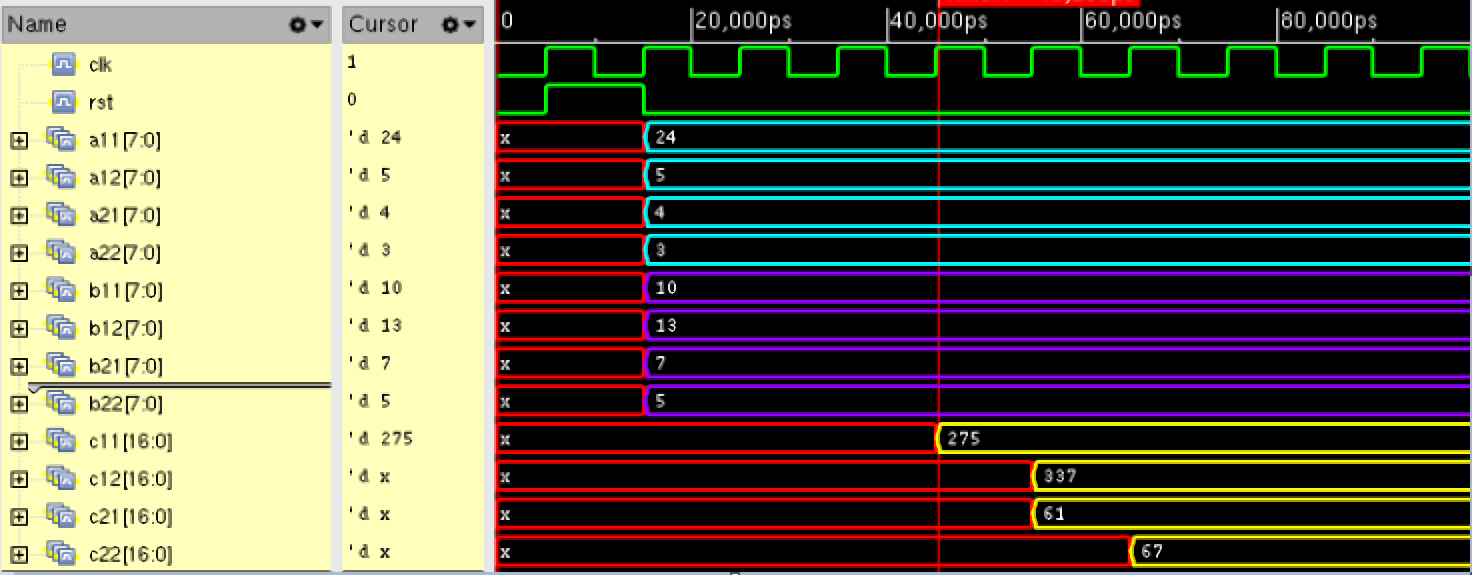

# **3. Physical Design** 

## **3.1 Constraint File for the Matrix Multiplier**

In [ ]:
%%writefile constraint.sdc

create_clock -period 10.0 -name clk -waveform {0.0 5.0} [get_ports {clk}]
set_clock_uncertainty 0.05 [get_clocks {clk}]

set_input_delay -clock clk -max 3.0 {a11 a12 a21 a22 b11 b12 b21 b22 rst}
set_input_transition -rise 0.5 -fall 0.5 {a11 a12 a21 a22 b11 b12 b21 b22 rst}
set_input_uncertainty 0.1 {a11 a12 a21 a22 b11 b12 b21 b22 rst}

set_output_delay -clock clk -max 2.0 {c11 c12 c21 c22}
set_output_transition -rise 0.4 -fall 0.4 {c11 c12 c21 c22}

set_max_delay -from clk -to {a11 a12 a21 a22 b11 b12 b21 b22 rst} 10.0
set_min_delay -from clk -to {a11 a12 a21 a22 b11 b12 b21 b22 rst} 1.0

set_load {c11 c12 c21 c22} 0.2

Overwriting constraint.sdc


## **3.2 Configuration File for the Matrix Multiplier**

In [ ]:
%%writefile config.json
{
  "DESIGN_NAME": "systolic_array",
    "VERILOG_FILES": "dir::systolic_array.v",
    "CLOCK_TREE_SYNTH": false,
    "CLOCK_PORT": null,
    "PL_RANDOM_GLB_PLACEMENT": true,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 1500 1550",
    "PL_TARGET_DENSITY": 0.72,
    "FP_PDN_AUTO_ADJUST": false,
    "FP_PDN_VPITCH": 25,
    "FP_PDN_HPITCH": 25,
    "FP_PDN_VOFFSET": 5,
    "FP_PDN_HOFFSET": 5,
    "DIODE_INSERTION_STRATEGY": 3
}




Overwriting config.json


## **3.3 Complete RTL-GDS Flow using OpenLane Skywater 130nm PDK**

In [ ]:
%env PDK=sky130A
!flow.tcl -design .

env: PDK=sky130A
OpenLane 2023.03.01_0_ge10820ec-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd
[INFO]: Optimization Standard Cell Library: sky130_fd_sc_hd
[INFO]: Run Directory: /content/runs/RUN_2023.03.30_00.39.48
[INFO]: Preparing LEF files for the nom corner...
[INFO]: Preparing LEF files for the min corner...
[INFO]: Preparing LEF files for the max corner...
[STEP 1]
[INFO]: Running Synthesis (log: runs/RUN_2023.03.30_00.39.48/logs/synthesis/1-synthesis.log)...
[STEP 2]
[INFO]: Running Single-Corner Static Timing Analysis (log: runs/RUN_2023.03.30_00.39.48/logs/synthesis/2-sta.log)...
[STEP 3]
[INFO]: Running Initial Floorplanning (log: runs/RUN_2023.03.30_00.39.48/logs/floorplan/3-ini

## **Layout Display**

This is the layout of my design 'Matrix Multiplier'.

GDS 
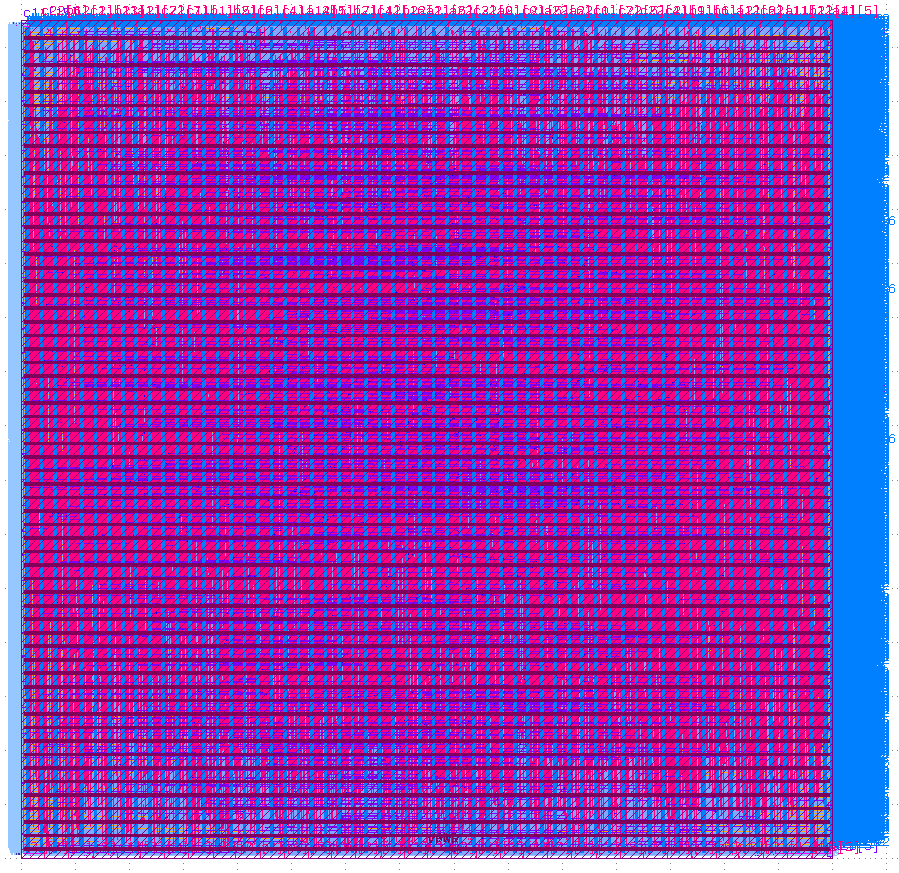



## **Design Summary**

In [ ]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(reports[-1])
df.transpose()

,0
design,/content
design_name,systolic_array
config,RUN_2023.03.30_00.39.48
flow_status,flow completed
total_runtime,0h57m12s0ms
routed_runtime,0h18m36s0ms
(Cell/mm^2)/Core_Util,2358.709677
DIEAREA_mm^2,2.325
CellPer_mm^2,1179.354839
OpenDP_Util,-1


## **References**

**[1]** *Norman P. Jouppi, Cliff Young, Nishant Patil, David Patterson, et al.,     “In-Datacenter Performance Analysis of a Tensor Processing Unit”, 44th Annual International Symposium on Computer Architecture, Association for Computing Machinery, pp. 1–12, 2017*

**[2]** *Zhijie Yang, Lei Wang, Dong Ding, Xiangyu Zhang, Yu Deng, et al., “Systolic Array Based Accelerator and Algorithm Mapping for Deep Learning Algorithms”, 15th IFIP International Conference on Network and Parallel Computing (NPC), pp.153-158, 2018*

**[3]** *Halil Snopce and Azir Aliu, “Comparison among Performance Measures for Parallel Matrix Multiplication Algorithms”, Research Journal of Applied Sciences, Engineering and Technology, (21): 4415-4422.*

**[4]** *Farrukh, Fasih Ud Din & Zhang, Chun & Yancao, Jiang & Zhang, Zhonghan & Ziqiang, Wang & Wang, Zhihua & Jiang, Hanjun, “Power Efficient Tiny Yolo CNN using Reduced Hardware Resources based on Booth Multiplier and WALLACE Tree Adders”, IEEE Open Journal of Circuits and Systems, PP. 1-1. 10.1109/OJCAS.2020.3007334, 2020*

**[5]** *Savita Nair, Ajit Sara,” A Review Paper on Comparison of Multipliers based on Performance Parameters”, International Journal of Computer Applications, Vol. 5, Issue. 4, pp. 6-9, 2014* 